## Baseline search engine for EviDENce

Search strategy

1. Collect corpus to perform search on
2. Index documents in corpus
3. Collect Keywords
4. Construct query
5. Perform search
6. Analyze results

In [1]:
# Imports from python libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string
import sys

# Imports from own script
from baseline_search import create_searchable_data
from baseline_search import create_lemma
from baseline_search import eng_to_dutch
from baseline_search import quote_phrase

# Define paths:

# Path to extracted folder with lemma fragments
root = os.path.join(os.sep,"media","sf_MartinedeVos")
search_dir = os.path.join(os.sep,root,"lem_par_100","lemma_preserve_paragraph")
# Path to reports on baseline_search results
report = os.path.join(root,"surfdrive","Projects", "EviDENce","Baseline")

**1. Collect corpus to perform search on**

Our corpus consists of oral history accounts.
These are broken up in text fragments -of 150 lemmas each- and can be found in a zip folder on surfdrive:

../Data/NR-teksts/EviDENce_NR_output/TargetSize150/Lemma_preserve_paragraph.zip

*Both the file names and path names are long. Make sure to extract the zip folder on high-level location on your computer a to avoid "path-too-long" error*


**2. Index all documents (i.e., lemma fragments) in the directory**

* Create Schema
* Add documents
* Perform indexing

_NB: this step only has to be run once, or when data is added or changed_

In [2]:
# The creation of an index is only needed once; after that, opending the existing index is sufficient
# in that case, the following line should be commented out

#create_searchable_data(search_dir)


**3. Collect list of keywords from CEO-ECB mappings**

Keywords are based on mappings from classes of the Circumstantial Event Ontology (CEO) on the ECB+ corpus

Preprocessing entails:
* manually select keywords related to violence
* express keywords as lemmas to ensure more effective matching 
* translate selected keywords to Dutch
* create dictionary with CEO class per unique keyword

In [3]:
mention_file ="../data/MdV_selectedCEOECB.csv"
mention_df = pd.read_csv(mention_file,sep=';',encoding = "ISO-8859-1")

mention_df['wordnet_lemma']=mention_df.apply(lambda x:create_lemma(x['Mention']), axis=1)

***NB: As automatic translation is not stable or does not provide sufficient results, please use following workaround***

In [4]:
translation_file = "../data/Translated_lemmas.csv"
translation_df = pd.read_csv(translation_file,sep=',',encoding = "ISO-8859-1") 

mention_df['Dutch']= translation_df['Dutch']
mention_df['Dutch']= mention_df.apply(lambda x:quote_phrase(x['Dutch']), axis=1)

In [5]:
ceo_mention_df = pd.DataFrame(data =mention_df[['CEO class','Dutch']]).drop_duplicates(subset= 'Dutch')
ceo_mention_df2 = ceo_mention_df.drop(columns=['Dutch']).set_index(ceo_mention_df['Dutch'])
ceo_mention_dict = ceo_mention_df2.transpose().to_dict(orient = 'records')[0]

**4. Construct query**

* Sort keywords
* Add double quotes to phrase queries
* Concatenate all keywords into one query string

In [9]:
nl_mention_list = list(ceo_mention_df['Dutch'])
nl_mention_query = ",".join(nl_mention_list)

**5. Perform search**

Using whoosh library:

* Define query parser: which schema, which search fields, AND/OR search
* Define searcher: which scoring approach
* Store info from results object in pandas dataframes

In [10]:
from collections import defaultdict
import pandas as pd
from whoosh import scoring
from whoosh import qparser
from whoosh.index import open_dir

indexdir = os.path.join(os.sep,search_dir,"indexdir")
ix = open_dir(indexdir)

parser = qparser.QueryParser("content", schema=ix.schema,group=qparser.OrGroup)
my_query = parser.parse(nl_mention_query)

cols_list = []
titles_list = []

with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
    results = searcher.search(my_query,limit=None, terms = True)
    for res in results:
        titles_list.append(res["title"])
        #row_dict = {}
        col_dict = defaultdict(int)
        hits = [term.decode('utf8')  for where,term in res.matched_terms()]
        for hit in hits:
            col_dict[hit]+= 1
            #row_dict[hit] = row_dict.get(hit, 0) + 1  
        cols_list.append(col_dict)

#Create a dataframe for results of this search, i.e. with a limited set of keywords 
results_df = pd.DataFrame(cols_list)
results_df.set_index([titles_list], inplace=True)

In [11]:
with ix.searcher() as searcher:
    index_dic = {doc['title']:[doc['textdata']] for doc in searcher.all_stored_fields()}   

index_df = pd.DataFrame.from_dict(index_dic, orient='index')    

Search results dataframe contains:
* only those keywords that are found in documents
* only those documents that have one or more keywords

Combined dataframe contains: 
* all keywords, also those that are not present in documents
* all documents, also those that have no keywords

In [13]:
#Create a dataframe for all docs and keywords with empty values
keywords_dic = {term:0 for term in nl_mention_list}
list_docs = [doc['title'] for doc in ix.searcher().documents()] 

all_df = pd.DataFrame(keywords_dic, index = list_docs)

# Create a dataframe for all docs and keywords with search results
merged_df = results_df.combine_first(all_df)

In [14]:
# Apparently phrase queries are still broken up in separate search terms
# this is shown by the surplus in columns in merged_df
surplus = [col for col in merged_df if col not in all_df]
# Remove these for now as a workaround; phrase queries should be fixed
merged_df = merged_df.drop(columns = surplus)

**6. Process and describe results** 

* Describe general characteristics of baseline search
    * Original corpus size
    * Number of keywords
    * csv with raw data

In [16]:
all_docs = ix.searcher().documents() 
summed_docs = sum(1 for x in all_docs)

summed_results =len(results_df.index)
percent_hits = (summed_results/summed_docs)*100

percent_keywords = (len(results_df.columns)/len(nl_mention_list))*100

In [17]:
report_summary = os.path.join(report,"Baseline_summary.txt")

with open(report_summary, 'w') as file_handler:
    # Add path to corpus
    file_handler.write("Original corpus size: %s \n"%summed_docs)
    file_handler.write("Number of snippets with keyword(s) present: %s \n"%summed_results)
    file_handler.write("Percentage snippets with keywords(s) in corpus: %s \n"%percent_hits)
    # Add path to keywords
    file_handler.write("Total number of unique keywords found: %s \n"%len(results_df.columns))
    file_handler.write("Percentage keywords found wrt to set used in query: %s \n"%percent_keywords)
    file_handler.close()

In [18]:
# Store raw data
report_raw_data = os.path.join(report,"Baseline_results.csv")
merged_df.to_csv(report_raw_data)

* Analyze results
    * nr keywords found per document
    * nr keywords found per category
    * nr hits found per keyword 
    * missed keywords


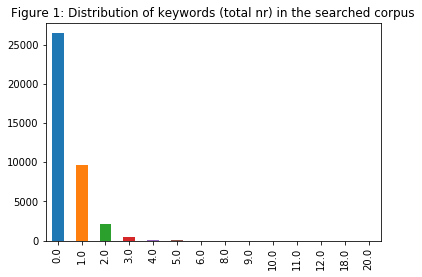

In [19]:
# Create Series for documents
sum_docs = pd.Series(merged_df.sum(axis=1)).value_counts(sort=True)
sum_docs = sum_docs.sort_index()

p1 = sum_docs.plot(kind='bar')

p1.set_title('Figure 1: Distribution of keywords (total nr) in the searched corpus')

p1.get_figure().savefig(os.path.join(report,"Hits_per_document.png"))

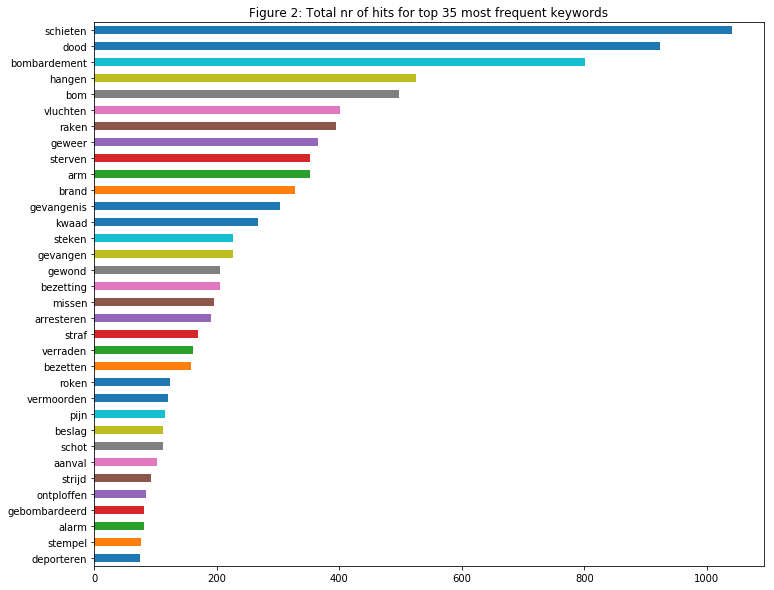

In [30]:
# Create Series for keywords
sum_keywords = pd.Series(merged_df.sum().iloc[:-1])

sum_keywords = sum_keywords.sort_values(ascending=True)
p2 = sum_keywords.iloc[-35:-1].plot(kind='barh', figsize = (12,10))

p2.set_title('Figure 2: Total nr of hits for top 35 most frequent keywords')

p2.get_figure().savefig(os.path.join(report,"Freq_keywords.png"))


In [ ]:
# Store list of keywords that were not present in analyzed corpus
report_missed_keywords = os.path.join(report,"Keywords_not_found_in_corpus.csv")

missed_keywords = sum_keywords[sum_keywords == 0]
missed_keywords.to_csv(report_missed_keywords)

In [ ]:
count_ceo = pd.Series(ceo_mention_df2['CEO class']).value_counts(sort=True,ascending=True).drop(labels=['/B','/M','/P','\P','/O'])

p3 = count_ceo.plot(kind='barh', figsize = (12,10))

p3.set_title('Figure 3: Distribution of classes of keywords in the query')

p3.get_figure().savefig(os.path.join(report,"Keyword_classes.png"))

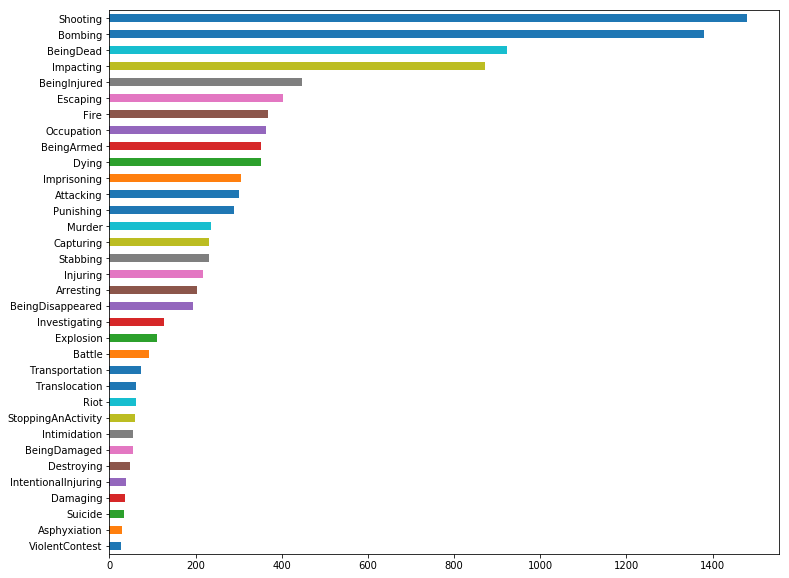

In [85]:
ceo_sum_keywords = [ceo_mention_dict[i] for i in sum_keywords.index]

serie = pd.Series(sum_keywords.values, index=ceo_sum_keywords)

res = serie.groupby(serie.index).sum()
res = res.drop(labels=['\P','/M','/B']).sort_values()

p4 = res.iloc[-35:-1].plot(kind='barh', figsize = (12,10))

p4.set_title('Figure 4: Distribution of classes of keywords in search results')

p4.get_figure().savefig(os.path.join(report,"Freq_keywords_classes.png"))

